This article will look at the benefits of using Principle Component Analysis to reduce the dimensionality of our datasesets. We will show that high dimensional datasets can most often times be expressed using only a few dimensions and that reducing dimensionality can make our datasets easier to work with and decrease the training time of our models.

## PCA Example on the MNIST Dataset

The MNIST dataset is composed of 28x28 pixel images of handwriten digits. Typically when training machine learning models MNIST vectorized by considering all the pixels as a 784 dimensional vector, or in other words, putting all the 28x28 pixels next to each other in an array. Not many datasets are greater than 784D (dimensions), and if you have ever worked with high dimensional datasets before we know that training time and prediction time are proportional to the size of the dataset and the number of features (dimensionality).

Let's take a look at how long it takes to train a Gaussian Classifier on the MNIST dataset:

### Train Using Gaussian Classifier

In [1]:
import loader as support #support library to read mnist files into memory
import gaussian_classifier as gf
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, Y_train = support.loadmnist('data/train-images-idx3-ubyte', 
'data/train-labels-idx1-ubyte')
X_test, Y_test = support.loadmnist('data/t10k-images-idx3-ubyte', 
'data/t10k-labels-idx1-ubyte')

In [3]:
X_train.shape

(60000, 784)

As you can see the we have 60,000 training examples with 784 features. Let's see how long it takes to train and predict on this high dimensional dataset:

In [4]:
clf = gf.GaussianClassifier(c=3400)
start = time.time()
clf.fit(X_train, Y_train)
Y = clf.predict(X_test)
errors = (Y_test != Y).sum();total = X_test.shape[0]
print("Error rate:\t %d/%d = %f" % ((errors,total,(errors/float(total)))))
end = time.time()
duration = end-start
duration

c=3400, cov_algo=numpy
Error rate:	 435/10000 = 0.043500


58.36238384246826

On my modest hardware (2016 macbook pro) it took about 1 minute (54 s) to train and predict with a 4.3% error rate -- pretty good!

Now let's experiment and see if we really need all those dimensions???

### PCA on MNIST

If we take all of our training examples and look at the variance of each feature, we can build a covariance matrix that will give us a quantifiable way to show variance across examples in a feature.


$$
\textbf{A} = \left(\begin{array}{cccc}a_{11} & a_{12} & \dots & a_{1p}\\ a_{21} & a_{22} & \dots & a_{2p}\\ \vdots & \vdots & \ddots & \vdots\\ a_{p1} & a_{p2} & \dots & a_{pp} \end{array}\right)
$$

In [29]:
cov = numpy.cov(X_train.T)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Once we have a convariance matrix, we can get the eigen values and the eigen vectors. 

In [90]:
evals, evecs = numpy.linalg.eig(cov)
evals = np.float64(evals)
evecs = np.float64(evecs)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


Each eigen value represents the variance of that feature. By definition, the total variation is given by the sum of the variances. It turns out that this is also equal to the sum of the eigenvalues of the covariance matrix. Thus, the total variation is:

$$
\sum_{j=1}^{p}s^2_j = s^2_1 + s^2_2 +\dots + s^2_p = \lambda_1 + \lambda_2 + \dots + \lambda_p = \sum_{j=1}^{p}\lambda_j
$$

In [91]:
total_variation = np.sum(evals)
np.float64(total_variation)

3428502.5747802099

As we can see from the output above, the total variance of our dataset is: `3428502.5747802104`. Now lets look at our eigenvalues as a fraction of the overall variance they should equal up to 1: 

1.0


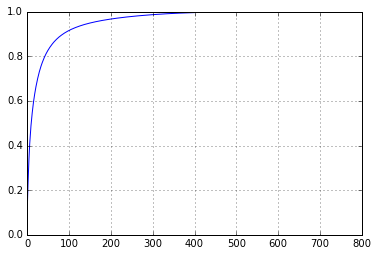

In [92]:
explained_variance_ratio = []
explained_variance = []
for i in range(0,X_train.shape[1]):
    explained_variance.append(evals[i])
    variance = evals[i] / total_variation
    explained_variance_ratio.append(variance)
explained_variance_ratio
print sum(explained_variance_ratio)

cumulative_explained = cumsum(explained_variance_ratio) 
plot(cumulative_explained);
grid()

This means that each feature has a variance that contributes to the overall variance. Is variance equally distributed among features? Are some features more expressive of the dataset and some not contributing any infomration? If so, then we can remove those features form our training set.

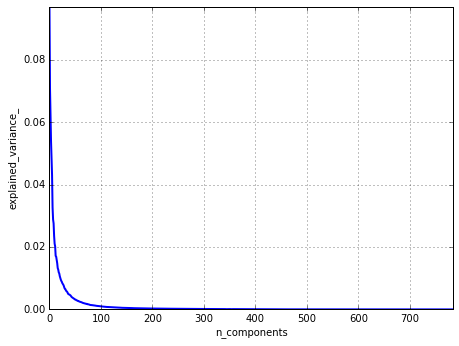

In [97]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(explained_variance_ratio, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
grid()

The above figure shows how much variance each feature contributes to the whole. The x axis represents our eigen value/vector pairs which correspond to a feature in the original dataset. We can see that after about 150 vectors, the subsequent vectors don't contibute much to the whole. We can probably cut out the last 634 vectors w/ot loosing much accuracy with our calssifier while at the same time decreasing training time!

In [100]:
np.sum(explained_variance_ratio[:150])

0.94835641881458321

In [101]:
np.sum(explained_variance_ratio[150:])

0.05164358118541678

Just to quantify the statement above: If we only use the first 150 vectors in our PCA analysis, we will capture 94% of the overall variance of our dataset and only loose about %5. Let's check if the we get a speed boost and not too much of an accuracy loss on our classifier

NOTE: At this point, I don't exactly know the algorithm to transform the training set into the new 150 dimensional dataset, so we will just let scikit do that for us :)

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
X_train_150 = pca.fit_transform(X_train)

from sklearn.cross_validation import train_test_split
_X_train, _X_test, _Y_train, _Y_test = train_test_split(X_train_150, Y_train, test_size=0.4, random_state=4)


In [131]:
_X_train.shape

(36000, 150)

As you can see we now have a 150 feature training set w/ only useful informtion, lets benchmark it against the classification job we did pre-PCA:

In [132]:
clf = gf.GaussianClassifier(c=1)
start = time.time()
clf.fit(_X_train, _Y_train)
Y = clf.predict(_X_test)
errors = (_Y_test != Y).sum(); total = _X_test.shape[0]
print("Error rate:\t %d/%d = %f" % ((errors, total, (errors/float(total)))))
end = time.time()
duration = end-start
duration

c=1, cov_algo=numpy
Error rate:	 1307/24000 = 0.054458


6.388982057571411

### Results

Our classifer finished in about 6.3 seconds and has an accuracty of about 5.5%. Thus we experienced a 90% training time decrease (6/58) and only a 1% accuracy loss (.054-.043).

|    |      Training Time (s)      |  Error Rate % |
|----------|:-------------:|------:|
| Original |  58 | 4.3 |
| PCA|    6.3   | 5.4  |

## PCA for Data Exploration

PCA is also helpfull when trying to visualize data, take the scikit Iris dataset as an example. It's 4 dimensional trainging set. If we do PCA on it reduce it to 2D we can now visualize the data:

explained variance ratio (first two components): [ 0.92461621  0.05301557]


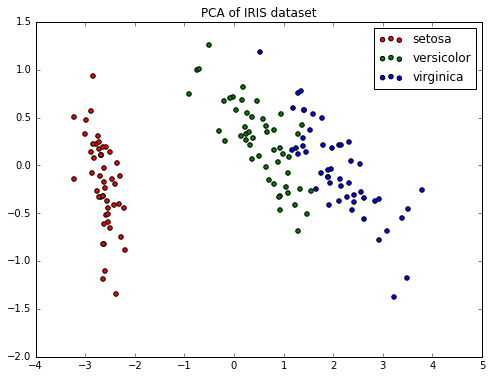

In [138]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(2, figsize=(8, 6))
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')



plt.show()